# Aprendizado de Máquina - Projeto 1
### Guilherme Pereira Corrêa 198397
### Bruno Moreira...

## Parte 1 - Métodos de clusterização

## Coleta e tratamento dos dados

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import nltk
from nltk.corpus import twitter_samples, stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import *
import string
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader



### Tarefa 2D padrão:

Vamos primeiro visualizar os dados da tarefa 2D padrão e entender como os mesmos estão distribuídos.

[[1490.     27.55]
 [1445.     28.35]
 [1415.     28.8 ]
 ...
 [3525.     26.  ]
 [3570.     26.15]
 [3440.     25.6 ]]


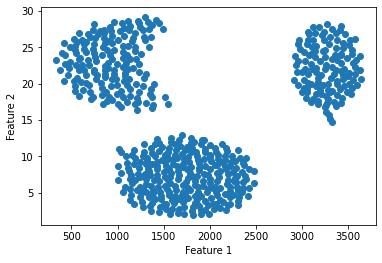

In [34]:
data = pd.read_csv('cluster.dat', delimiter=' ')
np_data = data.to_numpy()
print(np_data)
plt.scatter(np_data[:,0],np_data[:,1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Percebe-se, então, que a feature 1 deste conjunto de dados tem uma escala muito maior que a feature 2 e, portanto, pode afetar os resultados por ter um peso maior indesejado nos cálculos de distância que serão realizados. Normalizar estes dados pode resolver isso. Além disso, os dados estão distruidos crescentemente e, portanto, devem ser embaralhados na separação entre train set e test set para evitar bias.

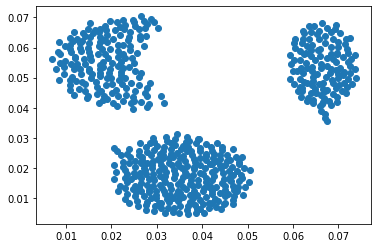

In [5]:
data_normalized = normalize(np_data,axis=0)
plt.scatter(data_normalized[:,0],data_normalized[:,1])
plt.show()

Agora vamos definir uma função para separar o dataset em training set e test set.

In [6]:
def split_dataset(data,train_proportion,test_proportion):
    np.random.shuffle(data)
    set_size = data.shape[0]
    train_size = int(set_size*train_proportion)
    train_set = data[:train_size]
    test_set = data[train_size:]
    return train_set,test_set

In [7]:
train_set,test_set = split_dataset(data_normalized,0.9,0.1)

### 2º conjunto de dados: tweets.
Foram escolhidos tweets para serem estudados como eles se comportam ao aplicar um algoritmo de clusterização. Porém, por se tratarem de textos, a forma como os mesmos são transformados em vetores de números (embedding) é crucial para o resultado. Neste projeto, esse processo foi dividido em três passos, onde existem diversas maneiras diferentes de se fazer cada um:

1 - Coleta e pré processamento dos tweets.

2 - Word embedding

3 - Document embedding

**1 - Coleta e pré processamento dos tweets**

O download dos tweets foi feito utilizando a biblioteca nltk, contendo 10000 tweets e uma anotação sobre o sentimento de cada um. Essa anotação é feita ao separar os mesmos em dois conjuntos, um para os tweets positivos e o outro para os tweets negativos, ou seja, como essa anotação não será utilizada neste trabalho, então esses dois conjuntos foram simplesmente concatenados um ao outro e então essa lista foi embaralhada a fim de evitar bias no momento de separar entre train set e test set.

O pré processamento de cada tweet foi feito ao remover stopwords, pontuação, links e hashtags, além de tokenização. Não foi feito stemming pois o modelo de embeddings utilizado considera as palavras completas e não suas raizes.

In [53]:
def process_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):
            # remove punctuation
             tweets_clean.append(word)
            #stem_word = stemmer.stem(word)  # stemming word
            #tweets_clean.append(stem_word)
    return tweets_clean

In [116]:
nltk.download('twitter_samples')
nltk.download('stopwords')
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')
all_tweets = all_positive_tweets + all_negative_tweets
#Shuffle para não ter bias na hora de separar entre train_set e test_set
np.random.shuffle(all_tweets)


[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\guipe\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guipe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**2 - Word embedding**

Utilizando a biblioteca gensim, foi feito o download do modelo GloVe de 25 dimensões pré treinado no Twitter, essa escolha foi feita pois esse modelo é um dos que apresentam melhores resultados atualmente e, principalmente, porque ele foi treinado no Twitter, e o contexto de treino é muito importante neste tipo de tarefa.

In [61]:
#Treina um modelo de embedding baseado no corpus existente, mas achamos mais conveniente usar um modelo pronto
#embedding_model = Word2Vec(tweets_processed,vector_size=300,min_count=1)

In [65]:
#Embedding GloVe que será utilizado
glove_vectors = gensim.downloader.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


**3 - Document embedding**

Há diversas maneiras de representar um tweet numericamente, mas muitas são custosas e, por conta disso, utilizamos uma ténica chamada Bag-of-words (BOW), onde a representação de um documento é dada pela média das representações de cada palavra que o compõe.

In [111]:
def get_tweet_embedding(tweet, embedding_model,dimension):
    tweet_embedding = np.zeros(dimension)
    processed_tweet = process_tweet(tweet)
    for word in processed_tweet:
        if embedding_model.get_index(word,False):
            tweet_embedding += embedding_model.get_vector(word,norm=0)
    return tweet_embedding

tweets_embedded = [get_tweet_embedding(tweet,glove_vectors,25) for tweet in all_tweets]

Resta, então, separar entre conjunto de treino e teste.

In [122]:
#Falta normalizar
#Transforma para numpy array
tweets_embedded_np = np.array(tweets_embedded)
tweets_train_set,tweets_test_set = split_dataset(tweets_embedded_np,0.9,0.1)

<class 'list'>
<class 'numpy.ndarray'>
9000
1000


### k-means

### Outro método

## Parte 2 - Redução de dimensionalidade